In [1]:
#!pip install ipywidgets > /dev/null

In [2]:
#!pip install matplotlib > /dev/null
#!pip install scikit-learn > /dev/null

In [3]:
#!pip install joblib >> /dev/null

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from numpy import mean

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score, cross_validate

from sklearn.metrics import precision_recall_curve, balanced_accuracy_score, precision_score, accuracy_score, recall_score, classification_report, PrecisionRecallDisplay, make_scorer, f1_score, average_precision_score
from sklearn.preprocessing import RobustScaler,OneHotEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import random
import time
from sklearn.impute import SimpleImputer
import shap
from lime import lime_tabular
from category_encoders import CatBoostEncoder
from model import ModelWrapper

In [5]:
np.random.seed(1)

# Data variables and basic functions

In [6]:
df = pd.read_csv('../datasets/transactions_480m.csv')
cols = ['Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?', 'Is Fraud?']
df = df[cols]

df['Class']  = df['Is Fraud?'].astype('category')
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
df.drop(['Is Fraud?'], axis=1, inplace=True)

df['Time'] = pd.to_datetime(df['Time'], format="%H:%M").astype('int64')/ 10**9

df['UC'] = df['Use Chip']
df['MN'] = df['Merchant Name']
df['MC'] = df['Merchant City']
df['MS'] = df['Merchant State']
df['errors'] = df['Errors?']
df.drop(['Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Errors?'], axis=1, inplace=True)

df.head()

,Year,Month,Day,Time,Amount,Zip,MCC,Class,UC,MN,MC,MS,errors
0,2009,6,10,-2.208906e+09,26.42,92335.0,5411,0,Swipe Transaction,"-7,27612092139916E+017",Fontana,CA,NaN
1,2018,4,1,-2.208927e+09,33.26,80301.0,5300,0,Chip Transaction,"3,76178035798556E+018",Boulder,CO,NaN
2,2000,8,30,-2.208917e+09,2.15,95822.0,5912,0,Swipe Transaction,"-5,4679223516925E+018",Sacramento,CA,NaN
3,2008,11,8,-2.208961e+09,29.16,77406.0,5411,0,Swipe Transaction,"9,70327976898217E+016",Richmond,TX,"Bad PIN,"
4,2009,12,13,-2.208955e+09,29.69,NaN,4784,0,Online Transaction,"-2,08849241165016E+018",ONLINE,NaN,NaN


In [7]:
fraud_percent      = df['Class'].value_counts()[0] / len(df) * 100
not_fraud_percent = df['Class'].value_counts()[1] / len(df) * 100

print("Porcentagem de transações fraudulentas %.2f"%fraud_percent)
print("Porcentagem de transações não fraudulentas %.2f"%not_fraud_percent)

Porcentagem de transações fraudulentas 99.88
Porcentagem de transações não fraudulentas 0.12


In [8]:
X = df.drop('Class', axis=1)
y = df['Class']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Year    480000 non-null  int64  
 1   Month   480000 non-null  int64  
 2   Day     480000 non-null  int64  
 3   Time    480000 non-null  float64
 4   Amount  480000 non-null  float64
 5   Zip     423296 non-null  float64
 6   MCC     480000 non-null  int64  
 7   UC      480000 non-null  object 
 8   MN      480000 non-null  object 
 9   MC      480000 non-null  object 
 10  MS      426406 non-null  object 
 11  errors  7683 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 43.9+ MB


In [9]:
default_pos_color = "#008bfb"

In [10]:
data_dict = {
    'logistic_regression_values': [],
    'logistic_regression_lime': [], 
    'logistic_regression_shap': [],
    'random_forest_lime': [],
    'random_forest_shap': [],
    'svm_lime': [],
    'svm_shap': [],
    'mlp_classifier_lime': [],
    'mlp_classifier_shap': [],
    'decision_tree_lime': [],
    'decision_tree_shap': []
}

def save_model_data(model, data, method):
    if isinstance(model, LogisticRegression):
        if method == 'lime': 
            data_dict['logistic_regression_lime'].append(data)
        else:
            if method == 'shap':
                data_dict['logistic_regression_shap'].append(data)
            else:
                data_dict['logistic_regression_values'].append(data)
    elif isinstance(model, RandomForestClassifier):
        if method == 'lime': 
            data_dict['random_forest_lime'].append(data)
        else:
            data_dict['random_forest_shap'].append(data)
    elif isinstance(model, LinearSVC):
        if method == 'lime': 
            data_dict['svm_lime'].append(data)
        else:
            data_dict['svm_shap'].append(data)
    elif isinstance(model, MLPClassifier):
        if method == 'lime': 
            data_dict['mlp_classifier_lime'].append(data)
        else:
            data_dict['mlp_classifier_shap'].append(data)
    elif isinstance(model, DecisionTreeClassifier):
        if method == 'lime': 
            data_dict['decision_tree_lime'].append(data)
        else:
            data_dict['decision_tree_shap'].append(data)
    else:
        print("Unrecognized model type")

In [11]:
def plot_results_logistic_regression_to_file(training_results):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        avg_model_coeficients = np.mean(abs(model.coef_), axis=0)
        top_indices = np.argsort(avg_model_coeficients)[::-1][:10]

        bars = axes[i].barh(np.arange(10), np.flip(avg_model_coeficients[top_indices]), align='center', color=default_pos_color)

        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(avg_model_coeficients[top_indices])[j]), \
                    ha='left', va='center', color=default_pos_color)
        
        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(fraud_sample.keys()[top_indices]))
        
        data = np.flip(fraud_sample.keys()[top_indices])
        save_model_data(model, data, 'reg')
    
    plt.suptitle("Regressão logística (Pesos do modelo)")
    plt.savefig("../results/new/synthetic/logistic_regression_feature_importance_plot.pdf", format="pdf")
    axes[0].set_ylabel('Nome do preditor')
    
def plot_lime_results_to_file_for_svm(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        explainer = training_results['lime_explainers'][i]
        
        start = time.time()
        explanation = explainer.explain_instance(
            data_row=fraud_sample,
            predict_fn=model._predict_proba_lr
        )
        end = time.time()
        print(f"Time used to calculate LIME values {end - start} seconds! \n")
        
        feature_names   = []
        feature_weights = []
        
        for index, tup in enumerate(explanation.as_map()[1]):
            feature_names.append(fraud_sample.keys()[tup[0]])
            feature_weights.append(abs(tup[1]))
        
        features_weights = np.array(np.abs(feature_weights)).mean(axis=0)
        top_indices = np.argsort(features_weights)[::-1][:10]
          
        bars = axes[i].barh(np.arange(10), np.flip(feature_weights), align='center', color=default_pos_color)
        
        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(feature_weights)[j]), \
                    ha='left', va='center', color=default_pos_color)

        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(feature_names))
        
        save_model_data(model, np.flip(feature_names), 'lime')

    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')
    
def plot_lime_results_to_file(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        model = training_results['models'][i]
        explainer = training_results['lime_explainers'][i]
        
        start = time.time()
        explanation = explainer.explain_instance(
            data_row=fraud_sample,
            predict_fn=model.predict_proba
        )
        end = time.time()
        print(f"Time used to calculate LIME values {end - start} seconds! \n")
        
        feature_names   = []
        feature_weights = []
        
        
        for index, tup in enumerate(explanation.as_map()[1]):
            feature_names.append(fraud_sample.keys()[tup[0]])
            feature_weights.append(abs(tup[1]))
        
        features_weights = np.array(np.abs(feature_weights)).mean(axis=0)
        top_indices = np.argsort(features_weights)[::-1][:10]
        
        
        bars = axes[i].barh(np.arange(10), np.flip(feature_weights), align='center', color=default_pos_color)
        
        for j, bar in enumerate(bars):
            le = round(np.flip(feature_weights)[j], 3)
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(le), \
                    ha='left', va='center', color=default_pos_color)

        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(feature_names))
        
        save_model_data(model, np.flip(feature_names), 'lime')
    
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')
    
def plot_shap_results_to_file(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        start = time.time()
        model = training_results['models'][i]
        explainer   = training_results['shap_explainers'][i]
        shap_values = explainer(fraud_sample.values.reshape(1,-1)).values
        end = time.time()
        print(f"Time used to calculate SHAP values {end - start} seconds! \n")
        
        if (shap_values.ndim == 3):
            fraud_shap_values = shap_values[0][:, 1]
            fraud_shap_values_reset = pd.Series(fraud_shap_values, index=pd.Index(fraud_sample.keys()))
            fraud_shap_values_abs = np.abs(fraud_shap_values_reset.values)
            fraud_shap_values_abs = fraud_shap_values_abs.reshape(1, -1)
            mean_shap_values = fraud_shap_values_abs.mean(axis=0)
        else:
            mean_shap_values = np.abs(shap_values).mean(axis=0)

        top_indices = np.argsort(mean_shap_values)[::-1][:10]
        
        bars = axes[i].barh(np.arange(10), np.flip(mean_shap_values[top_indices]), align='center', color=default_pos_color)

        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(mean_shap_values[top_indices])[j]), \
                    ha='left', va='center', color=default_pos_color)
        
        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(    fraud_sample.keys()[top_indices]   ))
        
        data = np.flip(fraud_sample.keys()[top_indices])
        save_model_data(model, data, 'shap')
    
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')

# Training the models

In [12]:
decision_tree_params = {'max_depth': [None, 5, 10], 'random_state':[1]}
random_forest_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10], 'random_state':[1]}
logistic_regression_params = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver':['newton-cholesky'], 'max_iter':[2000, 5000], 'random_state':[1], 'n_jobs': [-1]}
svm_params = {'C': [0.1, 1, 10], 'random_state':[1], 'dual':[False]}
mlp_params = {'hidden_layer_sizes': [(100,), (50, 50)], 'max_iter':[200, 400], 'random_state':[1]}

In [13]:
decision_tree         = ModelWrapper(DecisionTreeClassifier(), decision_tree_params)
decision_tree_results = decision_tree.train(X, y, "synthetic")

2024-12-25 14:25:55,075 - INFO - Starting to train model DecisionTreeClassifier...
2024-12-25 14:25:55,237 - INFO - Start numerical imputation...
2024-12-25 14:25:55,795 - INFO - Finished numerical imputation. Time used: 0.56 seconds
2024-12-25 14:25:55,796 - INFO - Start categorical imputation...
2024-12-25 14:25:56,394 - INFO - Finished categorical imputation. Time used: 0.60 seconds
2024-12-25 14:25:56,395 - INFO - Start catboost encoding...
2024-12-25 14:25:57,640 - INFO - Finished catboost encoding. Time used: 1.25 seconds
2024-12-25 14:25:57,645 - INFO - Starting to scale data...
2024-12-25 14:25:57,834 - INFO - Finished scaling data. Time used: 0.19 seconds
2024-12-25 14:25:58,067 - INFO - Starting to calculate hyperparameters for DecisionTreeClassifier...
2024-12-25 14:26:35,399 - INFO - Finished hyperparameter calculation. Time used: 37.33 seconds
2024-12-25 14:26:35,400 - INFO - Best hyperparameters: {'max_depth': None, 'random_state': 1}
2024-12-25 14:26:52,768 - INFO - Star

In [14]:
print("Métricas árvore de decisão: \n")

print("Sensibilidade: %f\n"%np.mean(decision_tree_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(decision_tree_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(decision_tree_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(decision_tree_results['precision_scores']))
print("F1: %f\n"%np.mean(decision_tree_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(decision_tree_results['auprc_scores']))

Métricas árvore de decisão: 

Sensibilidade: 0.361218

Acurácia balanceada: 0.671244

Especificidade: 0.981270

Precisão: 0.023651

F1: 0.044297

AUPRC: 0.009621



In [15]:
logistic_regression         = ModelWrapper(LogisticRegression(), logistic_regression_params)
logistic_regression_results = logistic_regression.train(X, y, "synthetic")

2024-12-25 14:31:00,149 - INFO - Starting to train model LogisticRegression...
2024-12-25 14:31:00,249 - INFO - Start numerical imputation...
2024-12-25 14:31:00,807 - INFO - Finished numerical imputation. Time used: 0.56 seconds
2024-12-25 14:31:00,808 - INFO - Start categorical imputation...
2024-12-25 14:31:01,426 - INFO - Finished categorical imputation. Time used: 0.62 seconds
2024-12-25 14:31:01,426 - INFO - Start catboost encoding...
2024-12-25 14:31:02,689 - INFO - Finished catboost encoding. Time used: 1.26 seconds
2024-12-25 14:31:02,694 - INFO - Starting to scale data...
2024-12-25 14:31:02,885 - INFO - Finished scaling data. Time used: 0.19 seconds
2024-12-25 14:31:03,116 - INFO - Starting to calculate hyperparameters for LogisticRegression...
2024-12-25 14:31:14,026 - INFO - Finished hyperparameter calculation. Time used: 10.91 seconds
2024-12-25 14:31:14,028 - INFO - Best hyperparameters: {'C': 0.1, 'max_iter': 2000, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 1, 'solv

In [16]:
print("Métricas regressão logística: \n")

print("Sensibilidade: %f\n"%np.mean(logistic_regression_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(logistic_regression_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(logistic_regression_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(logistic_regression_results['precision_scores']))
print("F1: %f\n"%np.mean(logistic_regression_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(logistic_regression_results['auprc_scores']))

Métricas regressão logística: 

Sensibilidade: 0.779146

Acurácia balanceada: 0.831261

Especificidade: 0.883376

Precisão: 0.008273

F1: 0.016371

AUPRC: 0.006723



In [17]:
random_forest         = ModelWrapper(RandomForestClassifier(), random_forest_params)
random_forest_results = random_forest.train(X, y, "synthetic")

2024-12-25 14:32:25,006 - INFO - Starting to train model RandomForestClassifier...
2024-12-25 14:32:25,080 - INFO - Start numerical imputation...
2024-12-25 14:32:25,645 - INFO - Finished numerical imputation. Time used: 0.57 seconds
2024-12-25 14:32:25,646 - INFO - Start categorical imputation...
2024-12-25 14:32:26,271 - INFO - Finished categorical imputation. Time used: 0.63 seconds
2024-12-25 14:32:26,272 - INFO - Start catboost encoding...
2024-12-25 14:32:27,500 - INFO - Finished catboost encoding. Time used: 1.23 seconds
2024-12-25 14:32:27,506 - INFO - Starting to scale data...
2024-12-25 14:32:27,699 - INFO - Finished scaling data. Time used: 0.19 seconds
2024-12-25 14:32:27,931 - INFO - Starting to calculate hyperparameters for RandomForestClassifier...
2024-12-25 15:03:50,255 - INFO - Finished hyperparameter calculation. Time used: 1882.32 seconds
2024-12-25 15:03:50,256 - INFO - Best hyperparameters: {'max_depth': None, 'n_estimators': 200, 'random_state': 1}
2024-12-25 15:

In [18]:
print("Métricas floresta aleatória: \n")

print("Sensibilidade: %f\n"%np.mean(random_forest_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(random_forest_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(random_forest_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(random_forest_results['precision_scores']))
print("F1: %f\n"%np.mean(random_forest_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(random_forest_results['auprc_scores']))

Métricas floresta aleatória: 

Sensibilidade: 0.299440

Acurácia balanceada: 0.649029

Especificidade: 0.998619

Precisão: 0.313091

F1: 0.252924

AUPRC: 0.079280



In [19]:
SVM         = ModelWrapper(LinearSVC(), svm_params)
SVM_results = SVM.train(X, y, "synthetic")

2024-12-25 17:49:18,320 - INFO - Starting to train model LinearSVC...
2024-12-25 17:49:18,412 - INFO - Start numerical imputation...
2024-12-25 17:49:18,975 - INFO - Finished numerical imputation. Time used: 0.56 seconds
2024-12-25 17:49:18,975 - INFO - Start categorical imputation...
2024-12-25 17:49:19,587 - INFO - Finished categorical imputation. Time used: 0.61 seconds
2024-12-25 17:49:19,588 - INFO - Start catboost encoding...
2024-12-25 17:49:20,792 - INFO - Finished catboost encoding. Time used: 1.20 seconds
2024-12-25 17:49:20,797 - INFO - Starting to scale data...
2024-12-25 17:49:20,986 - INFO - Finished scaling data. Time used: 0.19 seconds
2024-12-25 17:49:21,214 - INFO - Starting to calculate hyperparameters for LinearSVC...
2024-12-25 17:50:23,305 - INFO - Finished hyperparameter calculation. Time used: 62.09 seconds
2024-12-25 17:50:23,306 - INFO - Best hyperparameters: {'C': 0.1, 'dual': False, 'random_state': 1}
2024-12-25 17:50:33,880 - INFO - Starting to create SHAP 

In [20]:
print("Métricas SVM: \n")

print("Sensibilidade: %f\n"%np.mean(SVM_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(SVM_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(SVM_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(SVM_results['precision_scores']))
print("F1: %f\n"%np.mean(SVM_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(SVM_results['auprc_scores']))

Métricas SVM: 

Sensibilidade: 0.774118

Acurácia balanceada: 0.832608

Especificidade: 0.891098

Precisão: 0.008796

F1: 0.017393

AUPRC: 0.007094



In [21]:
mlp         = ModelWrapper(MLPClassifier(), mlp_params)
mlp_results = mlp.train(X, y, "synthetic")

2024-12-25 17:56:24,639 - INFO - Starting to train model MLPClassifier...
2024-12-25 17:56:24,735 - INFO - Start numerical imputation...
2024-12-25 17:56:25,315 - INFO - Finished numerical imputation. Time used: 0.58 seconds
2024-12-25 17:56:25,316 - INFO - Start categorical imputation...
2024-12-25 17:56:25,927 - INFO - Finished categorical imputation. Time used: 0.61 seconds
2024-12-25 17:56:25,928 - INFO - Start catboost encoding...
2024-12-25 17:56:27,126 - INFO - Finished catboost encoding. Time used: 1.20 seconds
2024-12-25 17:56:27,131 - INFO - Starting to scale data...
2024-12-25 17:56:27,313 - INFO - Finished scaling data. Time used: 0.18 seconds
2024-12-25 17:56:27,546 - INFO - Starting to calculate hyperparameters for MLPClassifier...
2024-12-25 18:17:15,604 - INFO - Finished hyperparameter calculation. Time used: 1248.06 seconds
2024-12-25 18:17:15,605 - INFO - Best hyperparameters: {'hidden_layer_sizes': (50, 50), 'max_iter': 200, 'random_state': 1}
2024-12-25 18:23:10,639

In [22]:
print("Métricas ANN: \n")

print("Sensibilidade: %f\n"%np.mean(mlp_results['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(mlp_results['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(mlp_results['specificity_scores']))
print("Precisão: %f\n"%np.mean(mlp_results['precision_scores']))
print("F1: %f\n"%np.mean(mlp_results['f1_scores']))
print("AUPRC: %f\n"%np.mean(mlp_results['auprc_scores']))

Métricas ANN: 

Sensibilidade: 0.459818

Acurácia balanceada: 0.724677

Especificidade: 0.989537

Precisão: 0.055003

F1: 0.097811

AUPRC: 0.026321



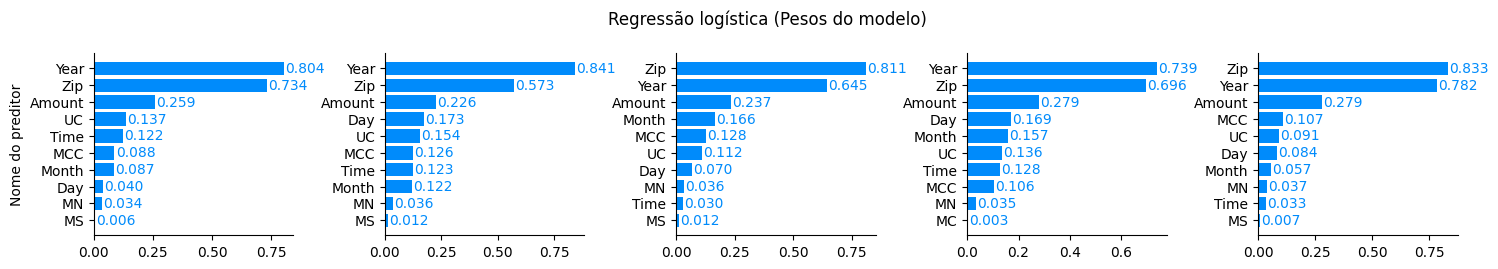

In [23]:
plot_results_logistic_regression_to_file(logistic_regression_results)

## SHAP plots

Time used to calculate SHAP values 2.470062017440796 seconds! 

Time used to calculate SHAP values 0.023602008819580078 seconds! 

Time used to calculate SHAP values 0.02319955825805664 seconds! 

Time used to calculate SHAP values 0.02342081069946289 seconds! 

Time used to calculate SHAP values 0.023302078247070312 seconds! 



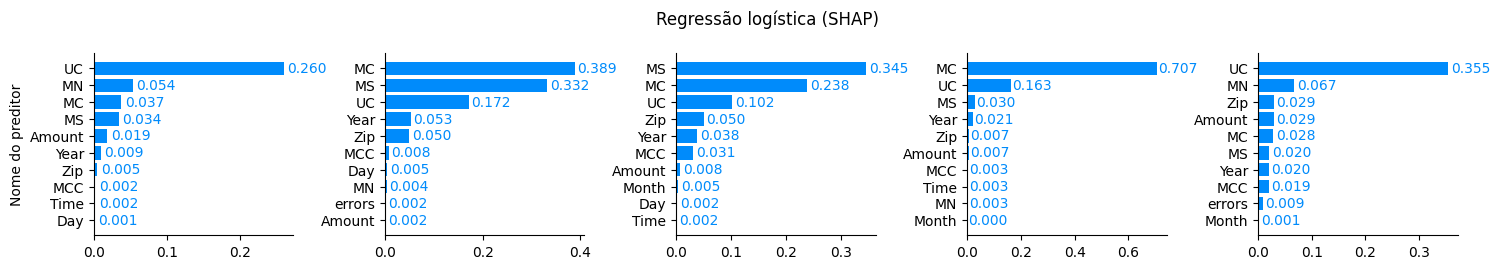

In [24]:
plot_shap_results_to_file(logistic_regression_results, "Regressão logística (SHAP)", "../results/new/synthetic/logistic_regression_feature_importance_plot(shap).pdf")

Time used to calculate SHAP values 0.027471303939819336 seconds! 

Time used to calculate SHAP values 0.029296398162841797 seconds! 

Time used to calculate SHAP values 0.026999950408935547 seconds! 

Time used to calculate SHAP values 0.02696824073791504 seconds! 

Time used to calculate SHAP values 0.025727272033691406 seconds! 



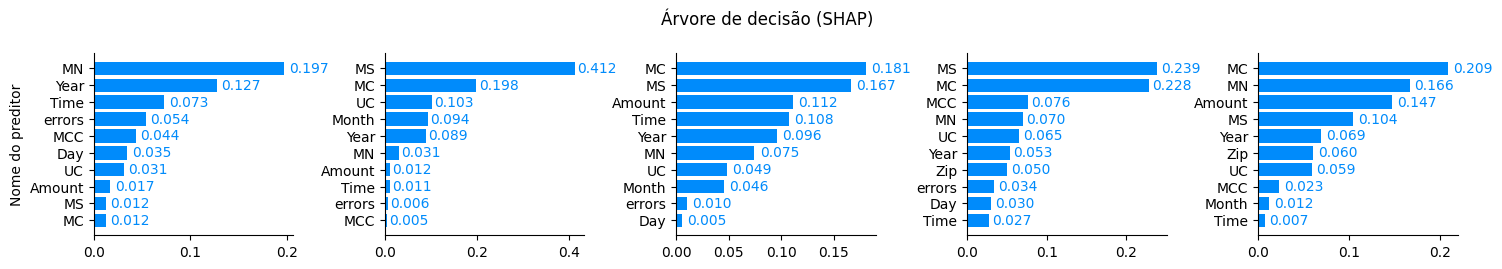

In [25]:
plot_shap_results_to_file(decision_tree_results, "Árvore de decisão (SHAP)", "../results/new/synthetic/decision_tree_feature_importance_plot(shap).pdf")

Time used to calculate SHAP values 1.269423007965088 seconds! 

Time used to calculate SHAP values 1.13338303565979 seconds! 

Time used to calculate SHAP values 0.5910301208496094 seconds! 

Time used to calculate SHAP values 1.1527245044708252 seconds! 

Time used to calculate SHAP values 1.1764190196990967 seconds! 



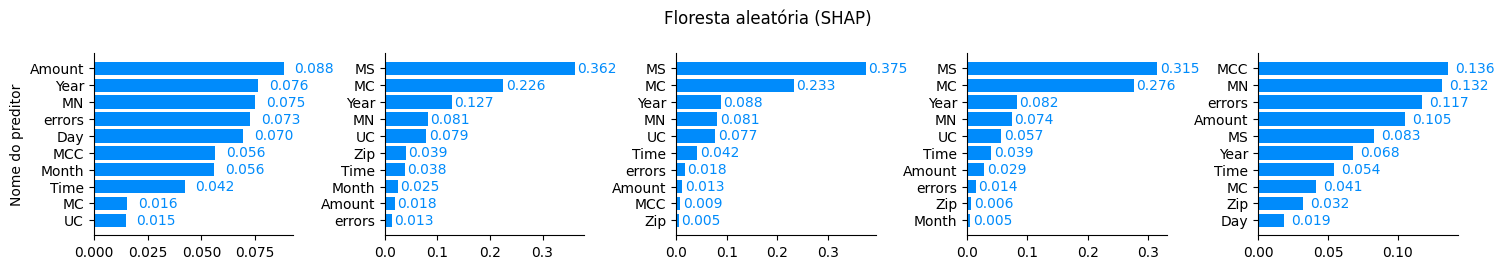

In [26]:
plot_shap_results_to_file(random_forest_results, "Floresta aleatória (SHAP)", "../results/new/synthetic/random_forest_feature_importance_plot(shap).pdf")

Time used to calculate SHAP values 0.03170657157897949 seconds! 

Time used to calculate SHAP values 0.026160001754760742 seconds! 

Time used to calculate SHAP values 0.029565811157226562 seconds! 

Time used to calculate SHAP values 0.02554631233215332 seconds! 

Time used to calculate SHAP values 0.026524782180786133 seconds! 



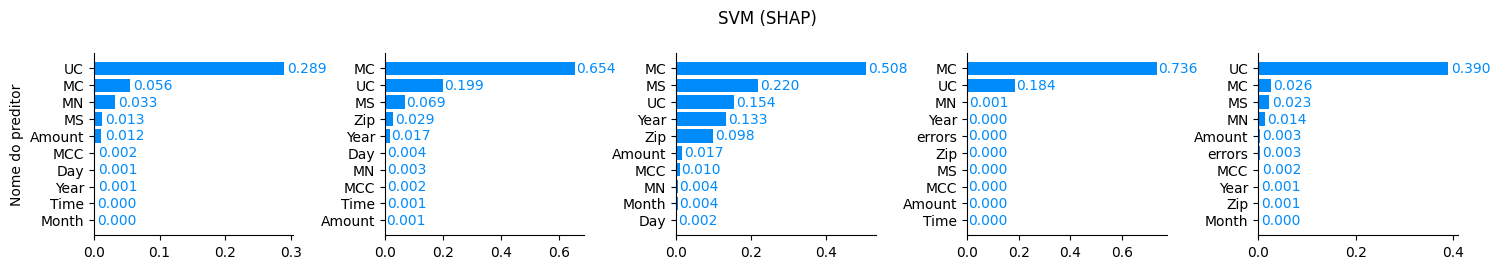

In [27]:
plot_shap_results_to_file(SVM_results, "SVM (SHAP)", "../results/new/synthetic/svm_feature_importance_plot(shap).pdf")

Time used to calculate SHAP values 0.0800027847290039 seconds! 

Time used to calculate SHAP values 0.06320309638977051 seconds! 

Time used to calculate SHAP values 0.0634772777557373 seconds! 

Time used to calculate SHAP values 0.05766725540161133 seconds! 

Time used to calculate SHAP values 0.04630589485168457 seconds! 



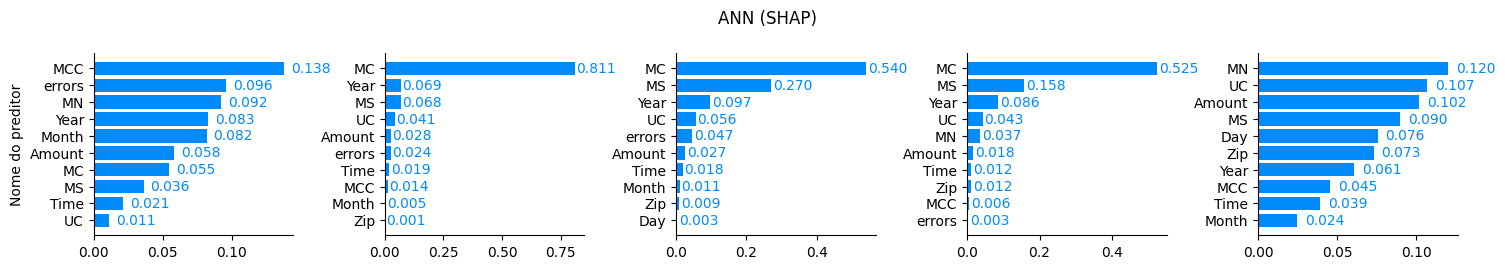

In [28]:
plot_shap_results_to_file(mlp_results, "ANN (SHAP)", "../results/new/synthetic/ann_feature_importance_plot(shap).pdf")

## LIME plots

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Time used to calculate LIME values 0.028090953826904297 seconds! 

Time used to calculate LIME values 0.021265745162963867 seconds! 

Time used to calculate LIME values 0.02092432975769043 seconds! 

Time used to calculate LIME values 0.01985335350036621 seconds! 

Time used to calculate LIME values 0.02099442481994629 seconds! 



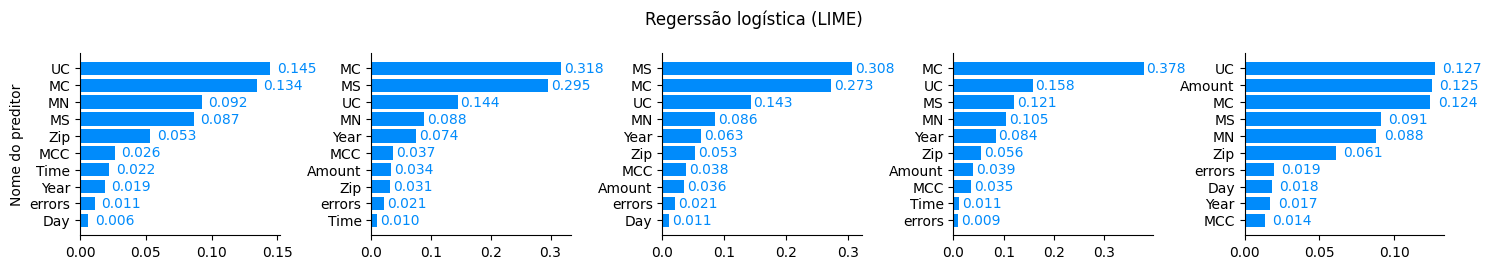

In [29]:
plot_lime_results_to_file(logistic_regression_results, "Regerssão logística (LIME)", "../results/new/synthetic/logistic_regression_feature_importance_plot(lime).pdf")

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


Time used to calculate LIME values 0.021401643753051758 seconds! 

Time used to calculate LIME values 0.022472858428955078 seconds! 

Time used to calculate LIME values 0.023540019989013672 seconds! 

Time used to calculate LIME values 0.025103092193603516 seconds! 

Time used to calculate LIME values 0.02539992332458496 seconds! 



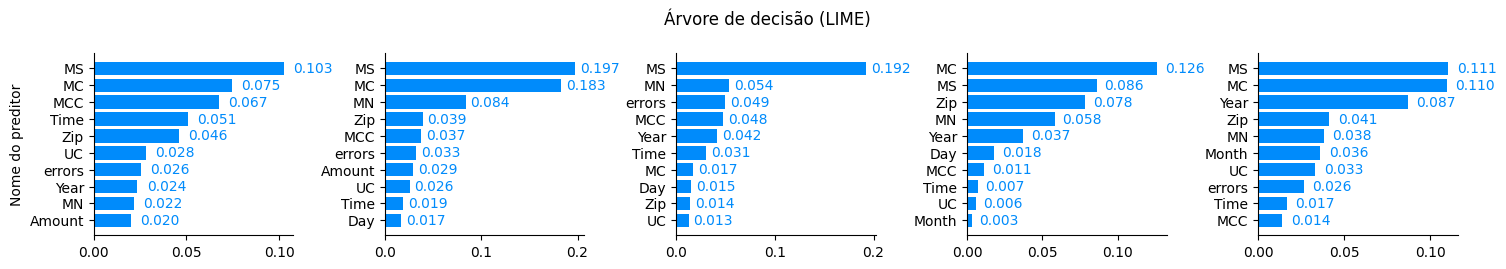

In [30]:
plot_lime_results_to_file(decision_tree_results, "Árvore de decisão (LIME)", "../results/new/synthetic/decision_tree_feature_importance_plot(lime).pdf")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Time used to calculate LIME values 0.1760411262512207 seconds! 

Time used to calculate LIME values 0.18704724311828613 seconds! 



X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Time used to calculate LIME values 0.11589384078979492 seconds! 

Time used to calculate LIME values 0.20976591110229492 seconds! 



X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Time used to calculate LIME values 0.21969866752624512 seconds! 



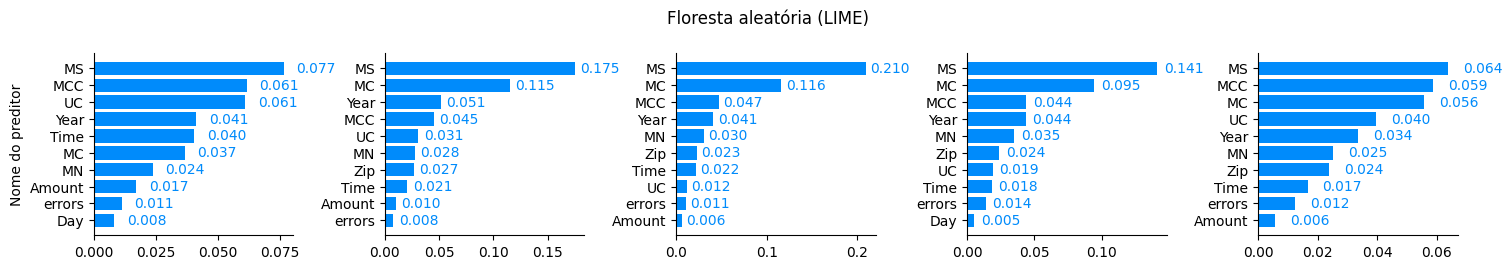

In [31]:
plot_lime_results_to_file(random_forest_results, "Floresta aleatória (LIME)", "../results/new/synthetic/random_forest_feature_importance_plot(lime).pdf")

X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names


Time used to calculate LIME values 0.02542591094970703 seconds! 

Time used to calculate LIME values 0.028148889541625977 seconds! 

Time used to calculate LIME values 0.027776479721069336 seconds! 

Time used to calculate LIME values 0.028316020965576172 seconds! 

Time used to calculate LIME values 0.02935194969177246 seconds! 



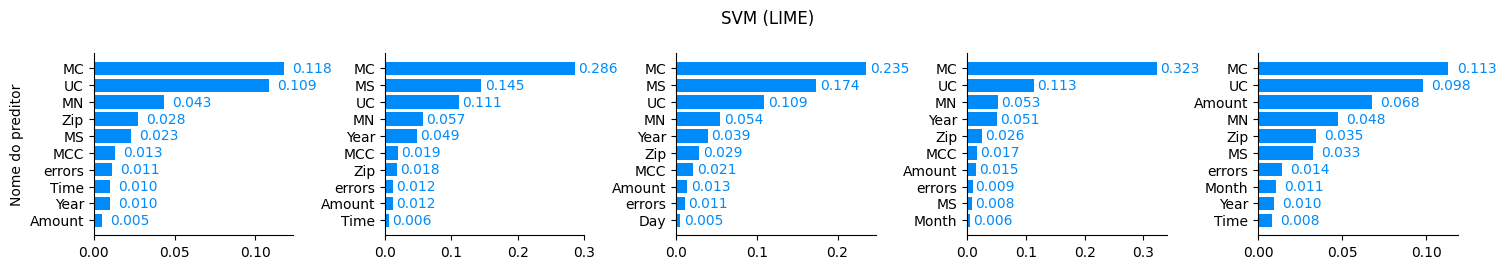

In [32]:
plot_lime_results_to_file_for_svm(SVM_results, "SVM (LIME)", "../results/new/synthetic/svm_feature_importance_plot(lime).pdf")

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


Time used to calculate LIME values 0.025852203369140625 seconds! 

Time used to calculate LIME values 0.026767730712890625 seconds! 

Time used to calculate LIME values 0.025840044021606445 seconds! 

Time used to calculate LIME values 0.02546977996826172 seconds! 

Time used to calculate LIME values 0.02504420280456543 seconds! 



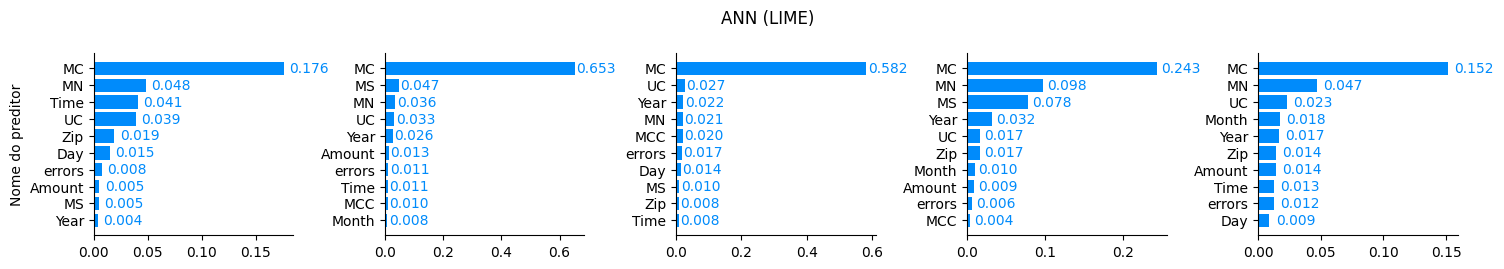

In [33]:
plot_lime_results_to_file(mlp_results, "ANN (LIME)", "../results/new/synthetic/ann_feature_importance_plot(lime).pdf")

# Calculando número de acertos e erros

In [34]:
def compute_agreement(data_dict):
    logistic_regression_values = data_dict['logistic_regression_values']
    num_agreements = {}
    for key in ['logistic_regression_lime', 'logistic_regression_shap', 'random_forest_lime', 'random_forest_shap', 'svm_lime', 'svm_shap', 'mlp_classifier_lime', 'mlp_classifier_shap', 'decision_tree_lime', 'decision_tree_shap']:
        num_agreements[key] = [sum([1 for s in data_dict[key][i] if s in logistic_regression_values[i]]) for i in range(len(logistic_regression_values))]
    return num_agreements


In [35]:
res = compute_agreement(data_dict)
print(res)

{'logistic_regression_lime': [8, 8, 8, 8, 8], 'logistic_regression_shap': [9, 8, 9, 9, 8], 'random_forest_lime': [8, 8, 8, 8, 8], 'random_forest_shap': [8, 8, 8, 8, 8], 'svm_lime': [8, 8, 8, 8, 8], 'svm_shap': [9, 9, 9, 8, 8], 'mlp_classifier_lime': [8, 8, 8, 8, 8], 'mlp_classifier_shap': [8, 8, 8, 8, 10], 'decision_tree_lime': [8, 8, 8, 9, 8], 'decision_tree_shap': [8, 8, 8, 8, 9]}
